# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*



# Setting up the workbench

In [1]:
from lakemodel_function import lake_problem
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);
from ema_workbench import (SequentialEvaluator, MultiprocessingEvaluator)
from ema_workbench import (Model, RealParameter, ScalarOutcome, Policy)
import seaborn as sns
import matplotlib.pyplot as plt
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
import pandas as pd

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# specifying 3 policy levers
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(3)] # we use time_horizon here

#specifying level value for each policy
policy1 = Policy("policy1", **{l.name:0 for l in lake_model.levers if l.name=='l0'})
policy2 = Policy("policy2", **{l.name:0.05 for l in lake_model.levers if l.name=='l1'})
policy3 = Policy("policy3", **{l.name:0.1 for l in lake_model.levers if l.name=='l2'})

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]


# Sensitivity Analysis for Policy 1

In [2]:
with SequentialEvaluator(lake_model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=100, uncertainty_sampling='sobol', policies=policy1)

experiments_p1, outcomes_p1 = sa_results

C:\Users\lekha\Anaconda3\envs\gds\lib\site-packages\SALib\sample\saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)
[MainProcess/INFO] performing 1200 scenarios * 1 policies * 1 model(s) = 1200 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 840 cases completed
[MainProcess/INFO] 960 cases completed
[MainProcess/INFO] 1080 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] experiments finished


In [3]:
experiments_p1.head()

,b,delta,mean,q,stdev,l0,scenario,policy,model
0,0.100513,0.952588,0.027910,3.217041,0.003229,0.0,0,policy1,lakeproblem
1,0.395483,0.952588,0.027910,3.217041,0.003229,0.0,1,policy1,lakeproblem
2,0.100513,0.944502,0.027910,3.217041,0.003229,0.0,2,policy1,lakeproblem
3,0.100513,0.952588,0.033496,3.217041,0.003229,0.0,3,policy1,lakeproblem
4,0.100513,0.952588,0.027910,3.741943,0.003229,0.0,4,policy1,lakeproblem


C:\Users\lekha\Anaconda3\envs\gds\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\lekha\Anaconda3\envs\gds\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


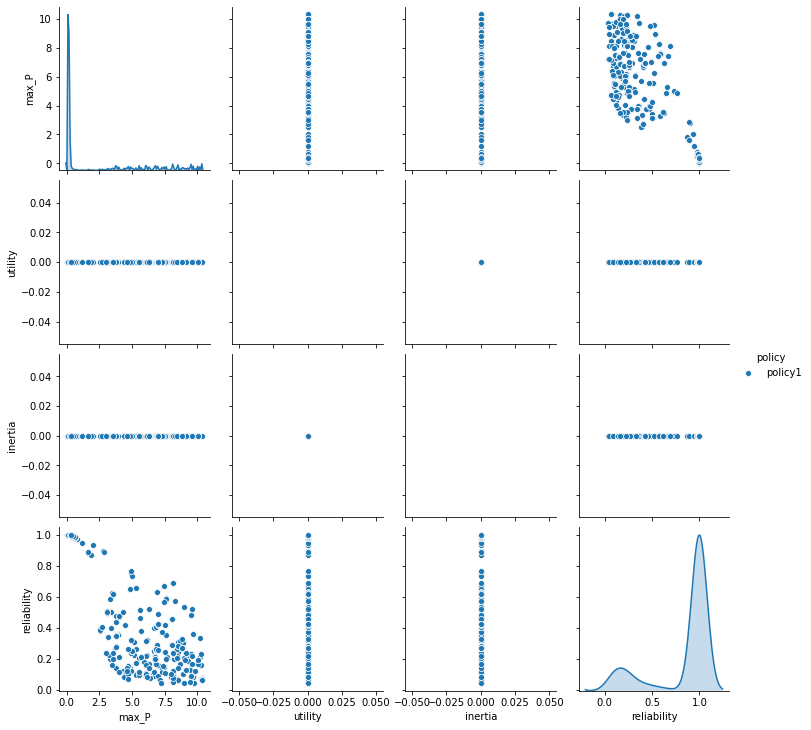

In [4]:
policies = experiments_p1['policy']

data = pd.DataFrame.from_dict(outcomes_p1)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes_p1.keys(), )
plt.show()

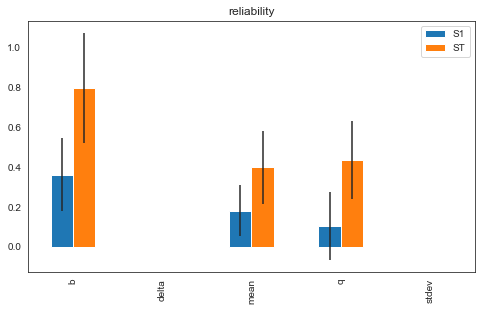

In [6]:
# Defining problem in SALib
problem = get_SALib_problem(lake_model.uncertainties)

output = pd.DataFrame.from_dict(outcomes_p1)

# for y in output.columns.to_list(): # iterating the columns of dataframe
Si = sobol.analyze(problem, output['reliability'].to_numpy(), calc_second_order=True,print_to_console=False) # Getting SAlib index for each column in output dataframe

# Processing the results for plotting the graph
scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
ax.set_title('reliability')
fig.subplots_adjust(bottom=0.3)
plt.show()

# Sensitivity Analysis for Policy 2

In [7]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=100, uncertainty_sampling='sobol', policies=policy2)
    
experiments_p2, outcomes_p2 = sa_results

[MainProcess/INFO] pool started
C:\Users\lekha\Anaconda3\envs\gds\lib\site-packages\SALib\sample\saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)
[MainProcess/INFO] performing 1200 scenarios * 1 policies * 1 model(s) = 1200 experiments
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 840 cases completed
[MainProcess/INFO] 960 cases completed
[MainProcess/INFO] 1080 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [8]:
experiments_p2.head()

,b,delta,mean,q,stdev,l1,scenario,policy,model
0,0.100513,0.952588,0.027910,3.217041,0.003229,0.05,1200,policy2,lakeproblem
1,0.395483,0.952588,0.027910,3.217041,0.003229,0.05,1201,policy2,lakeproblem
2,0.100513,0.944502,0.027910,3.217041,0.003229,0.05,1202,policy2,lakeproblem
3,0.100513,0.952588,0.033496,3.217041,0.003229,0.05,1203,policy2,lakeproblem
4,0.100513,0.952588,0.027910,3.741943,0.003229,0.05,1204,policy2,lakeproblem


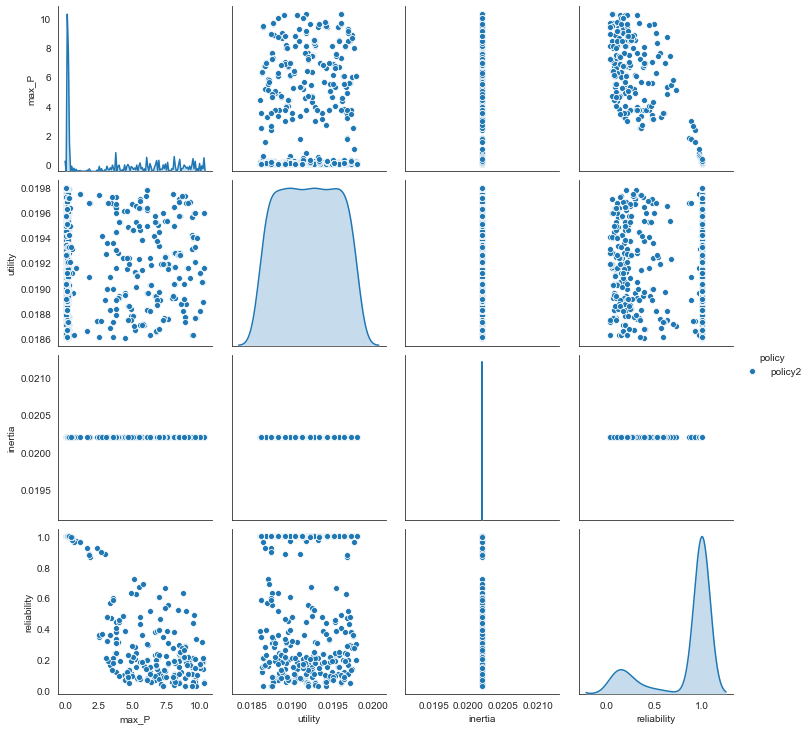

In [9]:
policies = experiments_p2['policy']

data = pd.DataFrame.from_dict(outcomes_p2)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes_p2.keys(), )
plt.show()

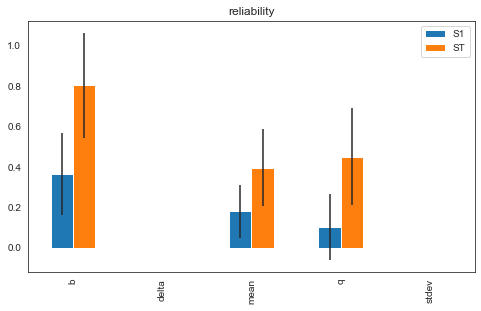

In [10]:
# Defining problem in SALib
problem = get_SALib_problem(lake_model.uncertainties)

output = pd.DataFrame.from_dict(outcomes_p2)

# for y in output.columns.to_list(): # iterating the columns of dataframe
Si = sobol.analyze(problem, output['reliability'].to_numpy(), calc_second_order=True,print_to_console=False) # Getting SAlib index for each column in output dataframe

# Processing the results for plotting the graph
scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
ax.set_title('reliability')
fig.subplots_adjust(bottom=0.3)
plt.show()

#### The error bars indicate the confidence intervals.

# Sensitivity Analysis for Policy 3

In [11]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=100, uncertainty_sampling='sobol', policies=policy3)
    
experiments_p3, outcomes_p3 = sa_results

[MainProcess/INFO] pool started
C:\Users\lekha\Anaconda3\envs\gds\lib\site-packages\SALib\sample\saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)
[MainProcess/INFO] performing 1200 scenarios * 1 policies * 1 model(s) = 1200 experiments
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 840 cases completed
[MainProcess/INFO] 960 cases completed
[MainProcess/INFO] 1080 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [12]:
experiments_p3.head()

,b,delta,mean,q,stdev,l2,scenario,policy,model
0,0.100513,0.952588,0.027910,3.217041,0.003229,0.1,2400,policy3,lakeproblem
1,0.395483,0.952588,0.027910,3.217041,0.003229,0.1,2401,policy3,lakeproblem
2,0.100513,0.944502,0.027910,3.217041,0.003229,0.1,2402,policy3,lakeproblem
3,0.100513,0.952588,0.033496,3.217041,0.003229,0.1,2403,policy3,lakeproblem
4,0.100513,0.952588,0.027910,3.741943,0.003229,0.1,2404,policy3,lakeproblem


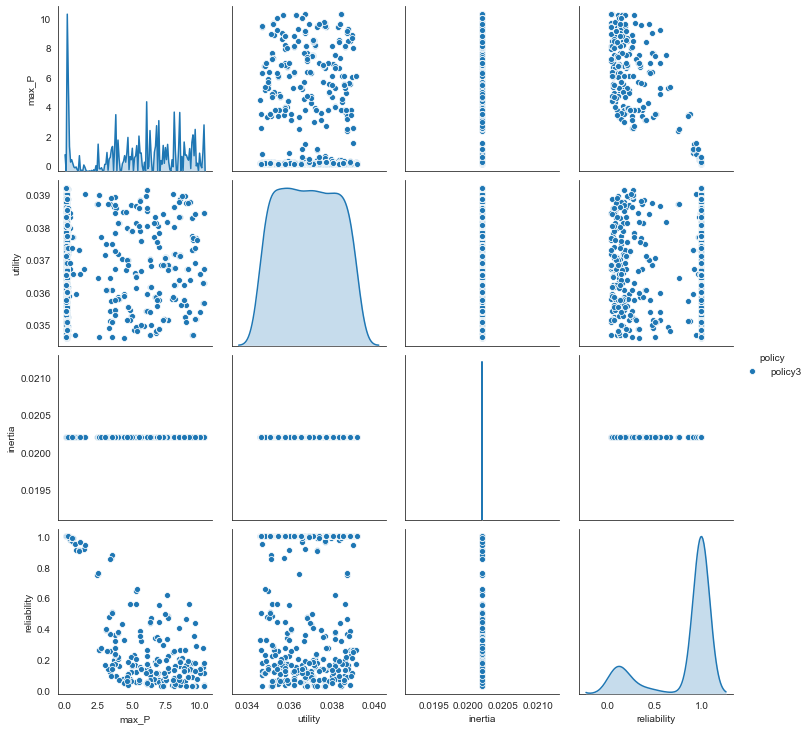

In [13]:
policies = experiments_p3['policy']

data = pd.DataFrame.from_dict(outcomes_p3)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes_p3.keys(), )
plt.show()

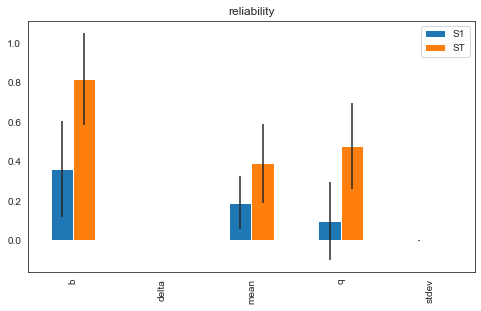

In [14]:
# Defining problem in SALib
problem = get_SALib_problem(lake_model.uncertainties)

output = pd.DataFrame.from_dict(outcomes_p3)

# for y in output.columns.to_list(): # iterating the columns of dataframe
Si = sobol.analyze(problem, output['reliability'].to_numpy(), calc_second_order=True,print_to_console=False) # Getting SAlib index for each column in output dataframe

# Processing the results for plotting the graph
scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
ax.set_title('reliability')
fig.subplots_adjust(bottom=0.3)
plt.show()

# Sensitivity Analysis with Extra Trees

2. Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*


Feature scoring is a family of techniques often used in machine learning to identify the most relevant features to include in a model. This is similar to one of the use cases for global sensitivity analysis, namely factor prioritisation.

# Policy1

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


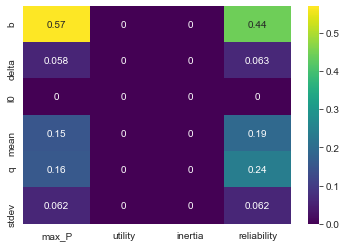

In [26]:
from ema_workbench.analysis import feature_scoring

x = experiments_p1
y = outcomes_p1

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

#### From the above results, we see that max_P is influenced maximum by b, and reliability is also driven by b. Utility and Inertia don't yield any result.

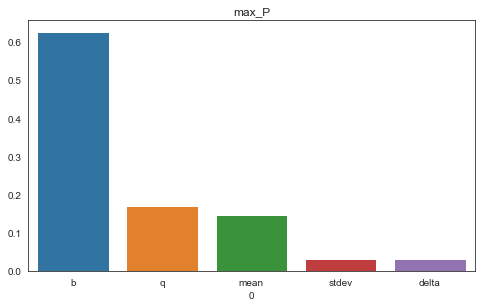

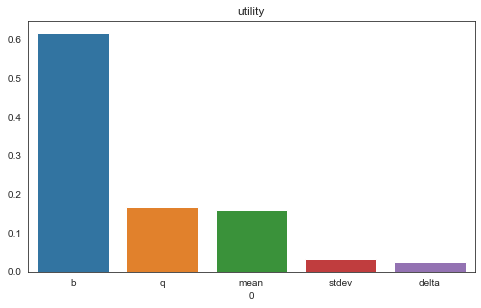

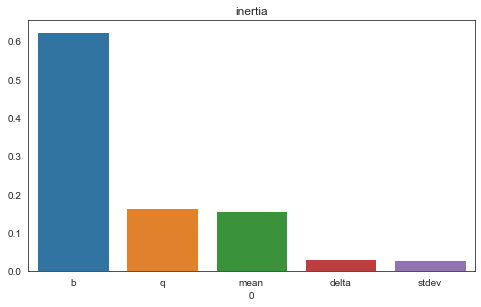

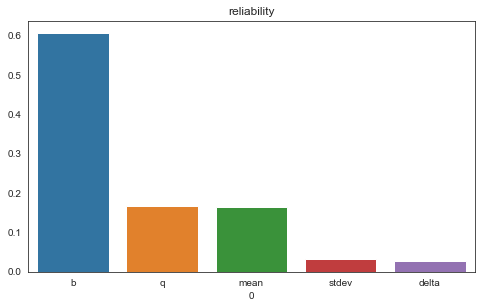

In [24]:
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

X = experiments_p1[['b', 'delta', 'mean','q','stdev']]
output = pd.DataFrame.from_dict(outcomes_p1)

for y in output.columns.to_list(): # iterating the columns of dataframe

    # getting the score for extra -tree analysis
    uncertainty_score, extra_trees_regressor = feature_scoring.get_ex_feature_scores(x = X,
                                        y = output.to_numpy(),
                                        nr_trees=100,
                                        max_features = 0.6,
                                        mode = RuleInductionType.REGRESSION)

    # plotting the results
#     sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8,6)
    ax = sns.barplot( data=uncertainty_score.transpose())
    ax.set_title(str(y))
    fig.subplots_adjust(bottom=0.3)
    plt.show()

# Policy2

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


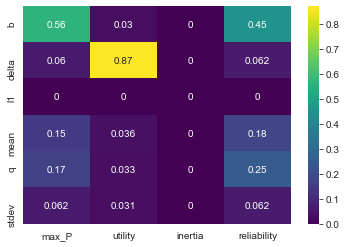

In [27]:
from ema_workbench.analysis import feature_scoring

x = experiments_p2
y = outcomes_p2

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

#### A release of 0.05 shows utility being influenced heavily by delta, while other parameters remain more or less the same as policy 1. 

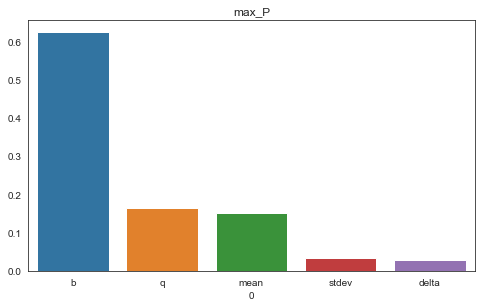

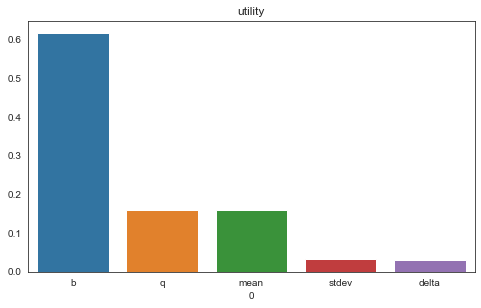

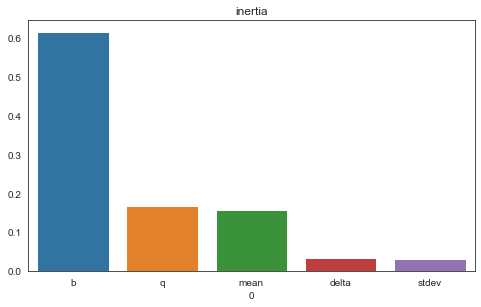

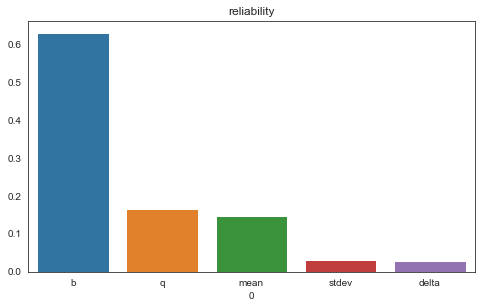

In [25]:
X = experiments_p2[['b', 'delta', 'mean','q','stdev']]
output = pd.DataFrame.from_dict(outcomes_p2)

for y in output.columns.to_list(): # iterating the columns of dataframe

    # getting the score for extra -tree analysis
    uncertainty_score, extra_trees_regressor = feature_scoring.get_ex_feature_scores(x = X,
                                        y = output.to_numpy(),
                                        nr_trees=100,
                                        max_features = 0.6,
                                        mode = RuleInductionType.REGRESSION)

    # plotting the results
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8,6)
    ax = sns.barplot( data=uncertainty_score.transpose())
    ax.set_title(str(y))
    fig.subplots_adjust(bottom=0.3)
    plt.show()

# Policy3

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


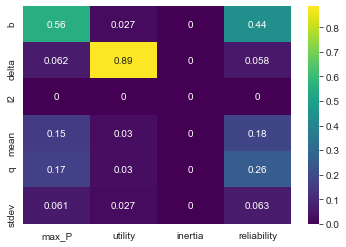

In [28]:
from ema_workbench.analysis import feature_scoring

x = experiments_p3
y = outcomes_p3

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

#### From the results, we see that max_P is influenced by b, while utility is driven by delta, reliability also by b while for inertia, the situation is a little bit less clear cut.

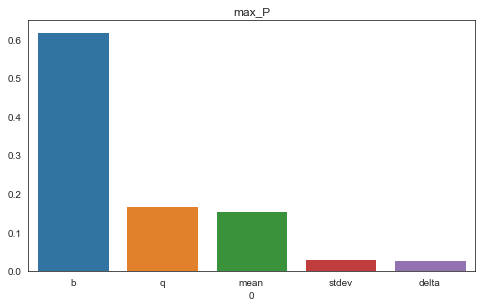

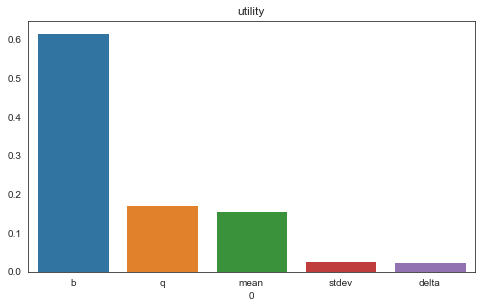

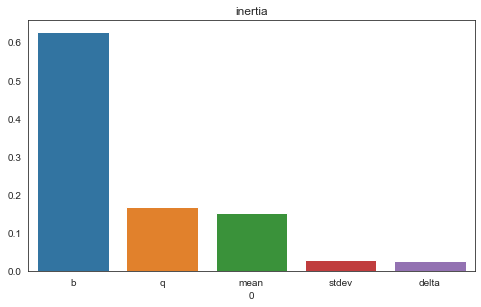

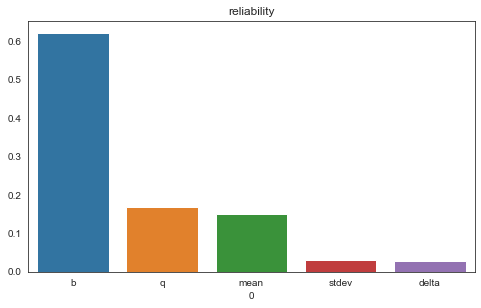

In [31]:
X = experiments_p3[['b', 'delta', 'mean','q','stdev']]
output = pd.DataFrame.from_dict(outcomes_p3)

for y in output.columns.to_list(): # iterating the columns of dataframe

    # getting the score for extra -tree analysis
    uncertainty_score, extra_trees_regressor = feature_scoring.get_ex_feature_scores(x = X,
                                        y = output,
                                        nr_trees=100,
                                        max_features = 0.6,
                                        mode = RuleInductionType.REGRESSION)

    # plotting the results
    fig, ax = plt.subplots(1)
    fig.set_size_inches(8,6)
    ax = sns.barplot( data=uncertainty_score.transpose())
    ax.set_title(str(y))
    fig.subplots_adjust(bottom=0.3)
    plt.show()

#### For all the policies and for all the outcomes, b had the maximum influence (about 0.6), which means that it contributes the maximum towards output uncertainty. 